## Residential Energy Consumption Survey (RECS)

### Nov 2019 Applied Data Science Meetup
### Portland Data Science Group
#### John Burt


#### Purpose of this notebook:

Explore the feature importances for a classifier trained to output whether a customer is likely experiencing economic hardship. 

Method: 
- Create a hardship score based on the features:
    - SCALEB, Frequency of reducing or forgoing basic necessities due to home energy bill
    - SCALEG, Frequency of keeping home at unhealthy temperature
    - SCALEE, Frequency of receiving disconnect notice


- Create an input dataset using the other features, but dropping:
    - Features directly related to the hardship features,
    - Features with string variables or NaNs


- Train a RandomForestClassifier with the data


- Plot the most important features.


In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

srcdir = './data/'

# load the data
df = pd.read_csv(srcdir+'recs2015_public_v4.csv') 


## Resample the data 

Note: this is Kenny's code

In [3]:
def resample_data(data):
    # calculate the number of times to duplicate each sample
    weights_scaled = ((data['NWEIGHT']/data['NWEIGHT'].min())).astype(int)
    # duplicate the original indices based on weights_scaled
    resampled_idx = data.index.repeat(weights_scaled.values)
    # create dummy dataframe with duplicated index and join original data
    resampled_data = pd.DataFrame(index=resampled_idx, columns=['dummy']).join(data)
    # delete dummy column and reset index
    resampled_data = resampled_data.drop('dummy', axis=1).reset_index(drop=True)
    return resampled_data

df = resample_data(df)

df.head()

,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,ZBASEFIN,ATTIC,ZATTIC,ATTICFIN,ZATTICFIN,STORIES,ZSTORIES,PRKGPLC1,ZPRKGPLC1,SIZEOFGARAGE,ZSIZEOFGARAGE,KOWNRENT,ZKOWNRENT,YEARMADERANGE,ZYEARMADERANGE,OCCUPYYRANGE,ZOCCUPYYRANGE,STUDIO,ZSTUDIO,BEDROOMS,ZBEDROOMS,NCOMBATH,ZNCOMBATH,NHAFBATH,ZNHAFBATH,OTHROOMS,ZOTHROOMS,TOTROOMS,ZTOTROOMS,WALLTYPE,ZWALLTYPE,ROOFTYPE,ZROOFTYPE,HIGHCEIL,ZHIGHCEIL,DOOR1SUM,ZDOOR1SUM,WINDOWS,ZWINDOWS,TYPEGLASS,...,DOLLPWTH,DOLLPCOK,DOLLPCDR,DOLLPNEC,GALLONFO,GALLONFOSPH,GALLONFOWTH,GALLONFONEC,BTUFO,BTUFOSPH,BTUFOWTH,BTUFONEC,DOLLARFO,DOLFOSPH,DOLFOWTH,DOLFONEC,TOTALBTU,TOTALDOL,TOTALBTUSPH,TOTALDOLSPH,TOTALBTUWTH,TOTALDOLWTH,TOTALBTUCOK,TOTALDOLCOK,TOTALBTUCDR,TOTALDOLCDR,TOTALBTUPL,TOTALDOLPL,TOTALBTUHTB,TOTALDOLHTB,TOTALBTUNEC,TOTALDOLNEC,WOODAMT,ZWOODAMT,WOODBTU,PELLETAMT,ZPELLETAMT,PELLETBTU,ELXBTU,PERIODEL,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,-2,0,0,-2,-2,20,0,1,0,2,0,1,0,7,0,8,0,-2,-2,3,0,2,0,1,0,4,0,7,0,4,0,1,0,1,0,2,0,41,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48974.57,1406.1,12469.727,176.59,17535.625,248.33,985.448,13.96,1727.078,92.89,0.0,0.0,0.0,0.0,1749.457,94.09,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
1,10001,4,10,METRO,U,2,0,0,0,-2,-2,0,0,-2,-2,20,0,1,0,2,0,1,0,7,0,8,0,-2,-2,3,0,2,0,1,0,4,0,7,0,4,0,1,0,1,0,2,0,41,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48974.57,1406.1,12469.727,176.59,17535.625,248.33,985.448,13.96,1727.078,92.89,0.0,0.0,0.0,0.0,1749.457,94.09,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
2,10001,4,10,METRO,U,2,0,0,0,-2,-2,0,0,-2,-2,20,0,1,0,2,0,1,0,7,0,8,0,-2,-2,3,0,2,0,1,0,4,0,7,0,4,0,1,0,1,0,2,0,41,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48974.57,1406.1,12469.727,176.59,17535.625,248.33,985.448,13.96,1727.078,92.89,0.0,0.0,0.0,0.0,1749.457,94.09,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
3,10001,4,10,METRO,U,2,0,0,0,-2,-2,0,0,-2,-2,20,0,1,0,2,0,1,0,7,0,8,0,-2,-2,3,0,2,0,1,0,4,0,7,0,4,0,1,0,1,0,2,0,41,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48974.57,1406.1,12469.727,176.59,17535.625,248.33,985.448,13.96,1727.078,92.89,0.0,0.0,0.0,0.0,1749.457,94.09,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
4,10001,4,10,METRO,U,2,0,0,0,-2,-2,0,0,-2,-2,20,0,1,0,2,0,1,0,7,0,8,0,-2,-2,3,0,2,0,1,0,4,0,7,0,4,0,1,0,1,0,2,0,41,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48974.57,1406.1,12469.727,176.59,17535.625,248.33,985.448,13.96,1727.078,92.89,0.0,0.0,0.0,0.0,1749.457,94.09,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2


### Remap column values for SCALE* features

I'm going to swap the coding values so that the numbers describe a range, from 0 (no months per year) to 3 (every month per year). 

Currently:
- 1 = Almost every month 
- 2 = Some months
- 3 = 1 or 2 months
- 0 = Never

Change to:
- 0 = Never
- 1 = 1 or 2 months
- 2 = Some months
- 3 = Almost every month 


In [4]:
# transform mapping
xform = {0:0, 1:3, 2:2, 3:1}

# remap the variables
df['SCALEBf'] = df['SCALEB'].map(xform)
df['SCALEGf'] = df['SCALEG'].map(xform)
df['SCALEEf'] = df['SCALEE'].map(xform)


### Histograms and correlations

All of the variables are significantly positively correlated. 

The histograms indicate that most samples are 0 (no economic distress).

Spearman rank correlations:

SCALEBf vs SCALEGf: coef=0.426, pval=0.00000
SCALEBf vs SCALEEf: coef=0.446, pval=0.00000
SCALEGf vs SCALEEf: coef=0.234, pval=0.00000

Histograms:


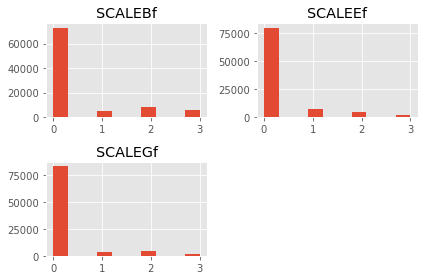

In [5]:
from scipy.stats import spearmanr

def print_corr(df, var1, var2):
    """Calc Spearman corr and print result"""
    coef, pval = spearmanr(df[var1],df[var2])
    print('%s vs %s: coef=%1.3f, pval=%1.5f'%(var1,var2,coef,pval))

print('Spearman rank correlations:\n')
print_corr(df,'SCALEBf','SCALEGf')
print_corr(df,'SCALEBf','SCALEEf')
print_corr(df,'SCALEGf','SCALEEf')

print('\nHistograms:')

df[['SCALEBf','SCALEGf','SCALEEf']].hist();
plt.tight_layout();


### Generate a PCA "hardship score"

Significan correlations between all vars indicates I can combine them to make a single score using PCA.

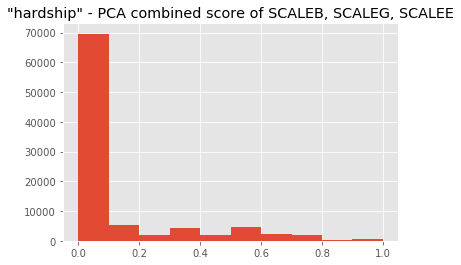

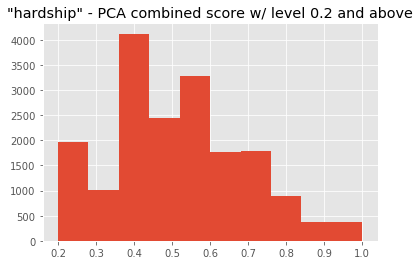

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# create PCA object
pca = PCA(n_components=1)

# do the PCA and save combined score to new 'hardship' column
scorefeatures = ['SCALEBf','SCALEGf','SCALEEf']
ycols = scorefeatures + ['SCALEB','SCALEG','SCALEE']

df['hardship'] = pca.fit_transform(df[scorefeatures])

# scale the hardship values between 0 - 1
df['hardship'] = MinMaxScaler().fit_transform(
    df['hardship'].values.reshape(-1, 1))

# plot histo of new hardship score
df['hardship'].hist();
plt.title('"hardship" - PCA combined score of SCALEB, SCALEG, SCALEE');

plt.figure()
df['hardship'].hist(range=[.2,1]);
plt.title('"hardship" - PCA combined score w/ level 0.2 and above');



## Select the input features

For this analysis I'm deleting any features directly related to economic hardship, since we already know they'll have high feature importance in any classifier model.

For my target, I'm defining a binary variable based on thresholding the hardship score: 0 = below threshold (no hardship), 1 = above threshold (hardship).

In [24]:
hardship_feat = ['SCALEBf','SCALEGf','SCALEEf',
                 'SCALEB','SCALEG','SCALEE'
                 'COLDMA', 'HOTMA',
                 'NOACBROKE', 'NOACEL',
                 'NOHEATDAYSf', 'NOHEATDAYS', 
                 'NOHEATHELPf', 'NOHEATHELP',
                 'NOACDAYSf', 'NOACDAYS',
                 'NOACHELPf', 'NOACHELP']

# drop features related to hardship
# drop columns that start with Z
# drop columns that start with BRRW
dropcols = ycols + hardship_feat + ['hardship']
Xcols = []
for s in df.columns:
    if s not in dropcols:
        if s[0] != 'Z' and 'BRRW' not in s:
            Xcols.append(s)
            
X = df[Xcols]
print(X.shape)            

# drop features with string values
okidx = []
for i in range(X.shape[1]):
    if type(X.iloc[0,i]) != str:
        okidx.append(i)
X = X[X.columns[okidx]]

# drop columns with NaNs
X = X.dropna(axis=1) 

print(X.shape)

# our target variable
# make it binary
threshold = 0.4
y = df['hardship'] > threshold
print(y.shape)


(92856, 436)
(92856, 431)
(92856,)


## Using RandomForest to assess feature importances

Create a RandomForestClassifier model and train it with the data.

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Print and plot the most important features

Feature ranking:
1. feature PAYHELP (0.076420)
2. feature DRAFTY (0.016552)
3. feature MONEYPY (0.011200)
4. feature HHAGE (0.009959)
5. feature NWEIGHT (0.009807)
6. feature TOTALBTUWTH (0.009445)
7. feature TOTALDOLNEC (0.008564)
8. feature BTUELTV1 (0.008284)
9. feature KWHTV2 (0.007636)
10. feature BTUELCW (0.007635)
11. feature BTUELTV2 (0.007237)
12. feature DOLELTVREL (0.007064)
13. feature KWHDWH (0.007028)
14. feature DOLLAREL (0.007024)
15. feature KWHTV1 (0.006991)
16. feature DBT1 (0.006954)
17. feature TOTALDOLSPH (0.006922)
18. feature NOHEATNG (0.006922)
19. feature KWHLGT (0.006745)
20. feature ENERGYASST (0.006635)


(-1, 20)

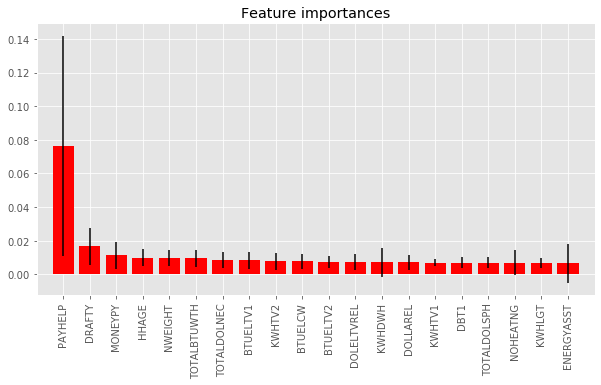

In [26]:
names = X.columns
numimportant = 20

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(numimportant):
    print("%d. feature %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=[10,5])
plt.title("Feature importances")
plt.bar(range(numimportant), importances[indices[:numimportant]],
       color="r", yerr=std[indices[:numimportant]], align="center")
plt.xticks(range(numimportant), names[indices[:numimportant]], rotation=90)
plt.xlim([-1, numimportant])


## Comparing values of important features<br>with vs without hardship

### Notes: 
- The further down the importance list, the less dissimilar the two categories are.
- Most of the values for each feature are codes, not numeric ranges, and some are inverted from what you'd expect!

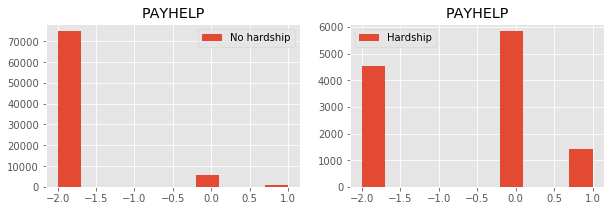

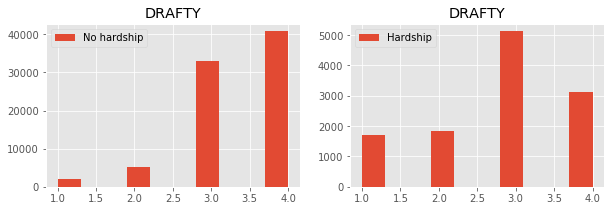

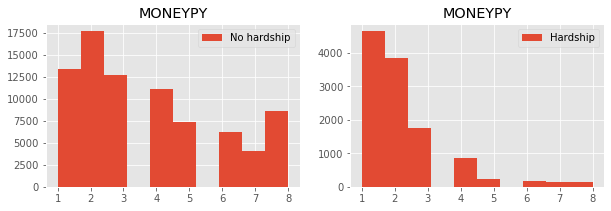

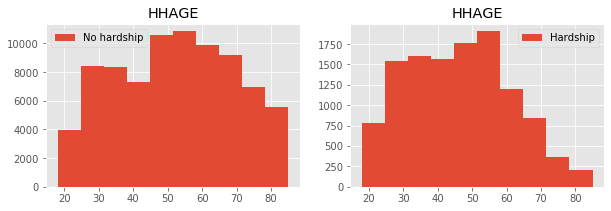

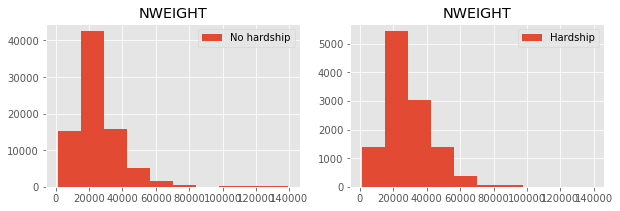

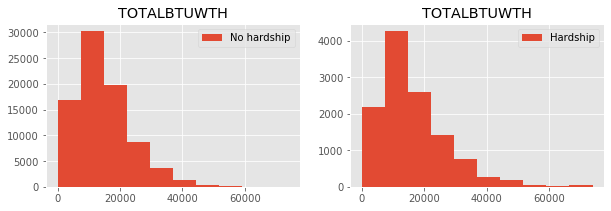

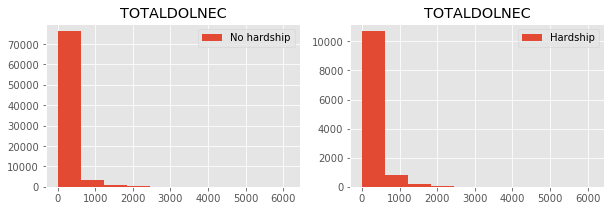

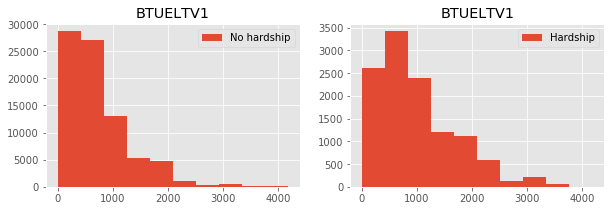

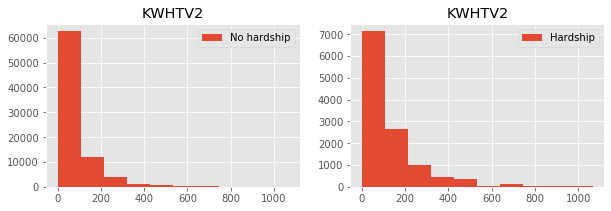

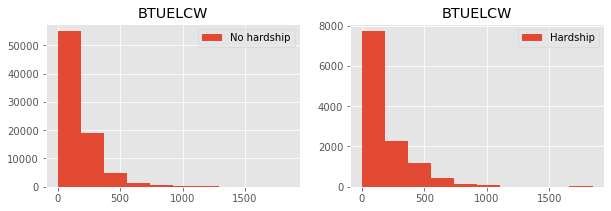

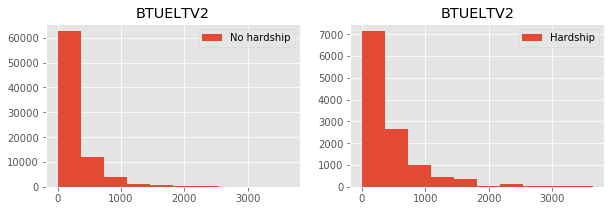

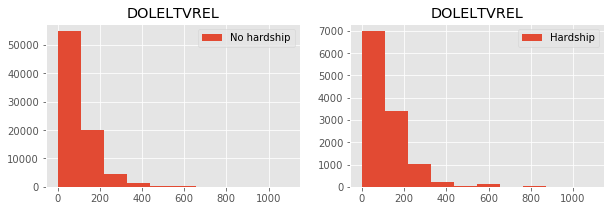

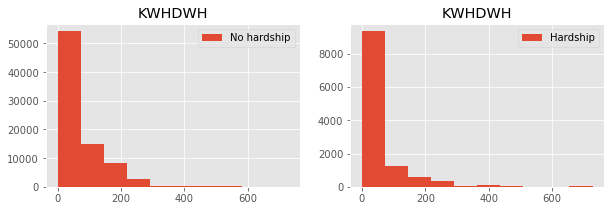

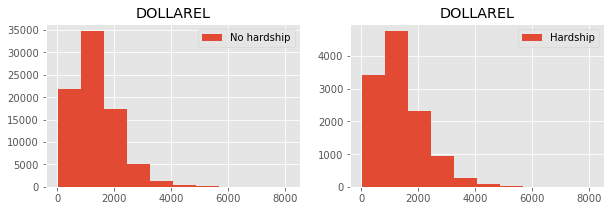

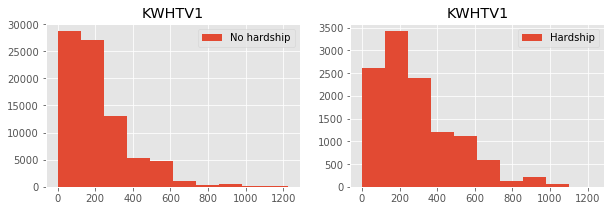

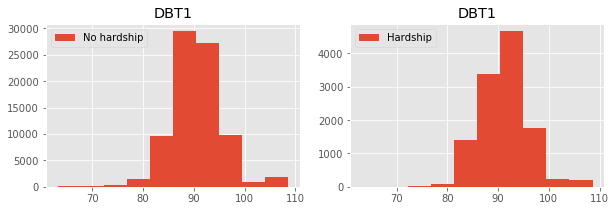

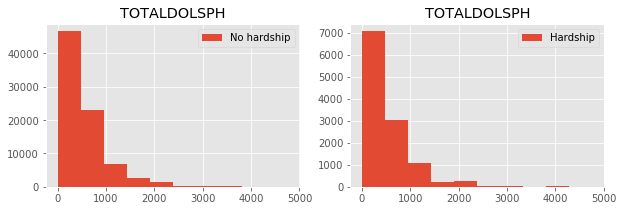

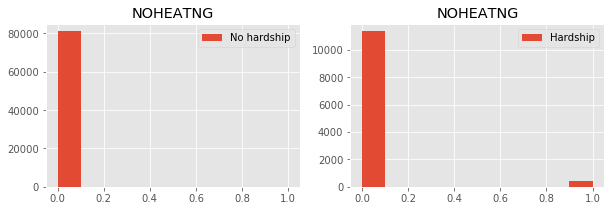

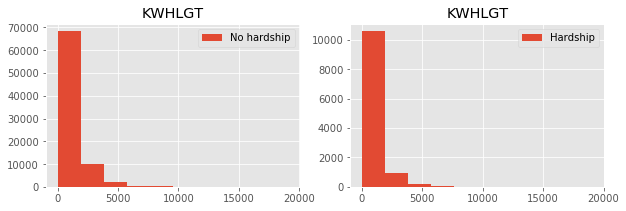

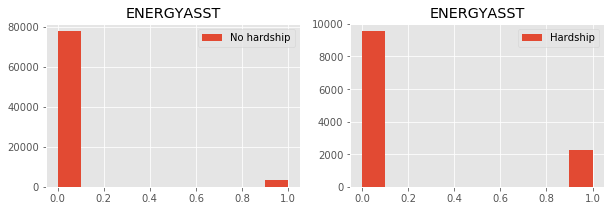

In [27]:
imp_colnames = names[indices[:numimportant]]
# imp_colnames = names[indices[:5]]

for name in imp_colnames:
    xrange = [X[name].min(), X[name].max()]
    plt.figure(figsize=[10,3])
    plt.subplot(1,2,1)
    X[name][y==0].hist(label='No hardship', range=xrange)
    plt.legend()
    plt.title(name);
    plt.subplot(1,2,2)
    X[name][y==1].hist(label='Hardship',range=xrange)
    plt.legend()
    plt.title(name);
